# 07a scATAC HSC Signac ChromVar

analysis of scATAC seq in HSCs using Signac and ChromVar

used this docker image

docker run --rm -d --name signac -p 8880:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work signac:0.2.5 



In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)
library(data.table)
library(SummarizedExperiment)
library(GenomicRanges)
library(diffloop)
library(tidyverse)
library(diffloop)
library(SingleCellExperiment)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.3”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

In [2]:
peaks <- diffloop::bedToGRanges("./raw_data/ATAC_LT/unique_LT.bed")

In [3]:
#clean up the peaks file get rid of the 'unconventional' chromosomes
peaks <- keepStandardChromosomes(peaks, species=NULL, pruning.mode=c("tidy"))

In [4]:
# function to get counts
getCountsFromFrags <- function(frag_gz_file,
                               peaks_gr,
                               barcodes){
  
  # Make GRanges of fragments that are solid for the cells that we care about
  frags_valid <- data.table::fread(paste0("zcat < ", frag_gz_file)) %>% 
    data.frame() %>% filter(V4 %in% barcodes) %>%  # filter for barcodes in our search set
    GenomicRanges::makeGRangesFromDataFrame(seqnames.field = "V1", start.field = "V2", end.field = "V3", keep.extra.columns = TRUE)
  
  # Get a denominator, per cell
  denom <- table(GenomicRanges::mcols(frags_valid)$V4)
  barcodes_found <- names(denom)
  
  # Get the overlaps with peaks
  ovPEAK <- GenomicRanges::findOverlaps(peaks_gr, frags_valid)
  
  # Establish a numeric index for the barcodes for sparse matrix purposes
  id <- factor(as.character(GenomicRanges::mcols(frags_valid)$V4), levels = barcodes_found)
  
  # Make sparse matrix with counts with peaks by  unique barcode
  countdf <- data.frame(peaks = S4Vectors::queryHits(ovPEAK),
                        sample = as.numeric(id)[S4Vectors::subjectHits(ovPEAK)]) %>%
    dplyr::group_by(peaks,sample) %>% dplyr::summarise(count = n()) %>% data.matrix()
  
  m <- Matrix::sparseMatrix(i = c(countdf[,1], length(peaks_gr)),
                            j = c(countdf[,2], length(barcodes_found)),
                            x = c(countdf[,3],0))
  colnames(m) <- barcodes_found
  
  # Make a polished colData
  colData <- data.frame(
    sample = barcodes_found,
    depth = as.numeric(denom),
    FRIP = Matrix::colSums(m)/as.numeric(denom)
  )
  # Make sure that the SE can be correctly constructed
  stopifnot(all(colData$sample == colnames(m)))
  
  # Make summarized Experiment
  SE <- SummarizedExperiment::SummarizedExperiment(
    rowRanges = peaks_gr,
    assays = list(counts = m),
    colData = colData
  )
  return(SE)
}

In [5]:
# Import PBMC to a summarized experiment
bc_pub_pbmc <- as.character(read.table("./raw_data/ATAC_LT/filtered_peak_bc_matrix/barcodes.tsv")[,1])
LT <- getCountsFromFrags("./raw_data/ATAC_LT/fragments.tsv.gz", peaks, bc_pub_pbmc)

# need to specify the rownames
temp <- DataFrame(LT@rowRanges)
rownames(LT) <- temp$X

#save as .rds object for later
saveRDS(LT, file = "./sc_objects/LT_macs2.rds")

Taking input= as a system command ('zcat < ./raw_data/ATAC_LT/fragments.tsv.gz') and a variable has been used in the expression passed to `input=`. Please use fread(cmd=...). There is a security concern if you are creating an app, and the app could have a malicious user, and the app is not running in a secure environment; e.g. the app is running as root. Please read item 5 in the NEWS file for v1.11.6 for more information and for the option to suppress this message.
`summarise()` regrouping output by 'peaks' (override with `.groups` argument)


In [6]:
LT <- readRDS("./sc_objects/LT_macs2.rds")

#read in metadata
metadata <- read.csv(
  file = "./raw_data/ATAC_LT/singlecell.csv",
  header = TRUE,
  row.names = 1
)

#convert to SingleCellExperiment - Seurat compatible format
LT <- as(LT, "SingleCellExperiment")

#convert to SingleCellExperiment - Seurat compatible format
LT <- as(LT, "SingleCellExperiment")
LT <- as.Seurat(LT, counts = "counts", data = "counts")
LT <- AddMetaData(object = LT, metadata = metadata)
LT@assays$peaks <- LT@assays$RNA
DefaultAssay(LT) <- 'peaks'

In [7]:
LT

An object of class Seurat 
364214 features across 730 samples within 2 assays 
Active assay: peaks (182107 features, 0 variable features)
 1 other assay present: RNA

In [8]:
fragment.path <- './raw_data/ATAC_LT/fragments.tsv.gz'

LT <- SetFragments(
  object = LT,
  file = fragment.path
)

In [9]:
# make column in metadata that denotes the nCounts in th count matrix

nCount_peaks = colSums(x = LT, slot = "counts")
LT$nCount_peaks = nCount_peaks

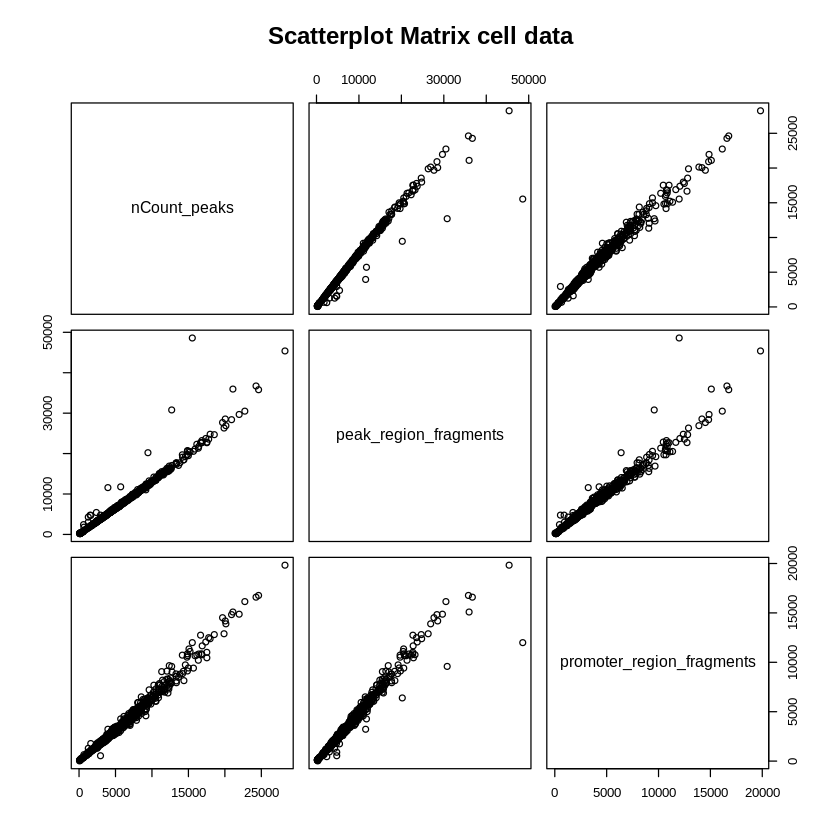

In [10]:
pairs(~nCount_peaks+peak_region_fragments+promoter_region_fragments,data = LT@meta.data,
   main = "Scatterplot Matrix cell data")

In [11]:
LT <- NucleosomeSignal(object = LT)

Extracting reads in requested region
Computing ratio of mononucleosomal to nucleosome-free fragments


Warning message:
"Removed 2 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

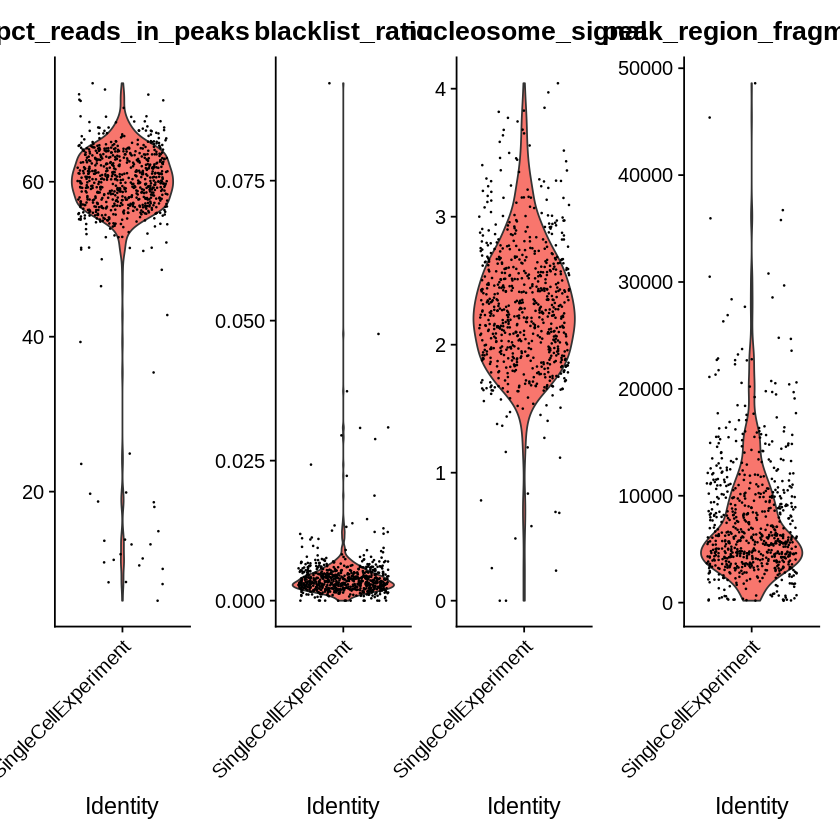

In [12]:
LT$pct_reads_in_peaks <- LT$nCount_peaks / LT$passed_filters * 100
LT$blacklist_ratio <- LT$blacklist_region_fragments / LT$nCount_peaks

VlnPlot(
  object = LT,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

Warning message:
"Removed 53 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

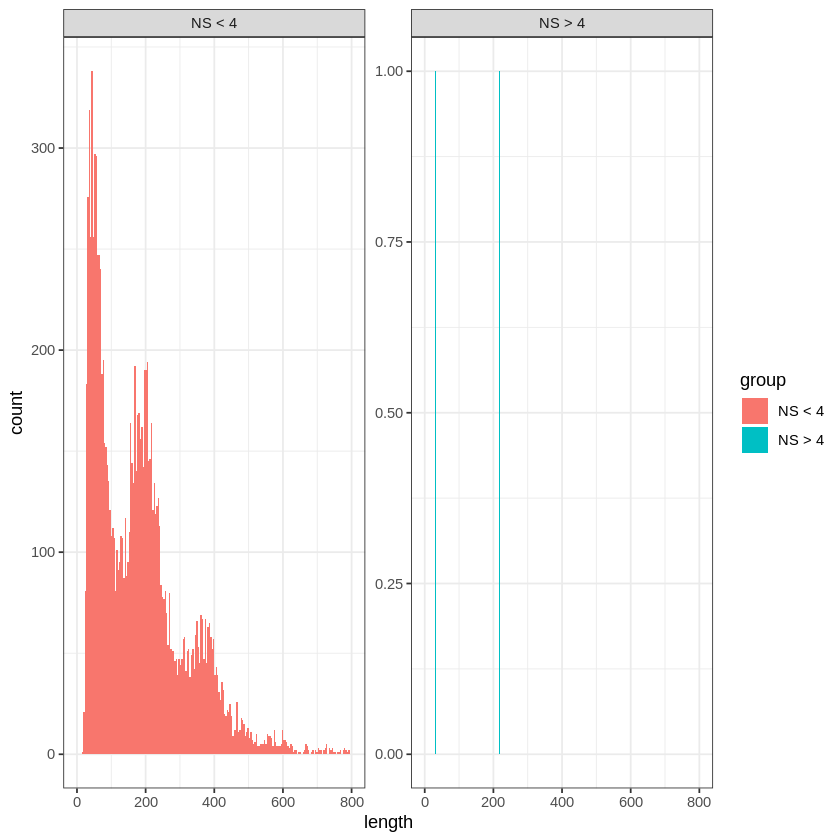

In [13]:
LT$nucleosome_group <- ifelse(LT$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = LT, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

In [14]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]

tss.ranges <- GRanges(
  seqnames = seqnames(gene.ranges),
  ranges = IRanges(start = start(gene.ranges), width = 2),
  strand = strand(gene.ranges)
)

seqlevelsStyle(tss.ranges) <- 'UCSC'
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 2000 TSSs
LT <- TSSEnrichment(object = LT, tss.positions = tss.ranges[1:2000])

Finding + strand cut sites
Finding - strand cut sites
Computing mean insertion frequency in flanking regions
Normalizing TSS score


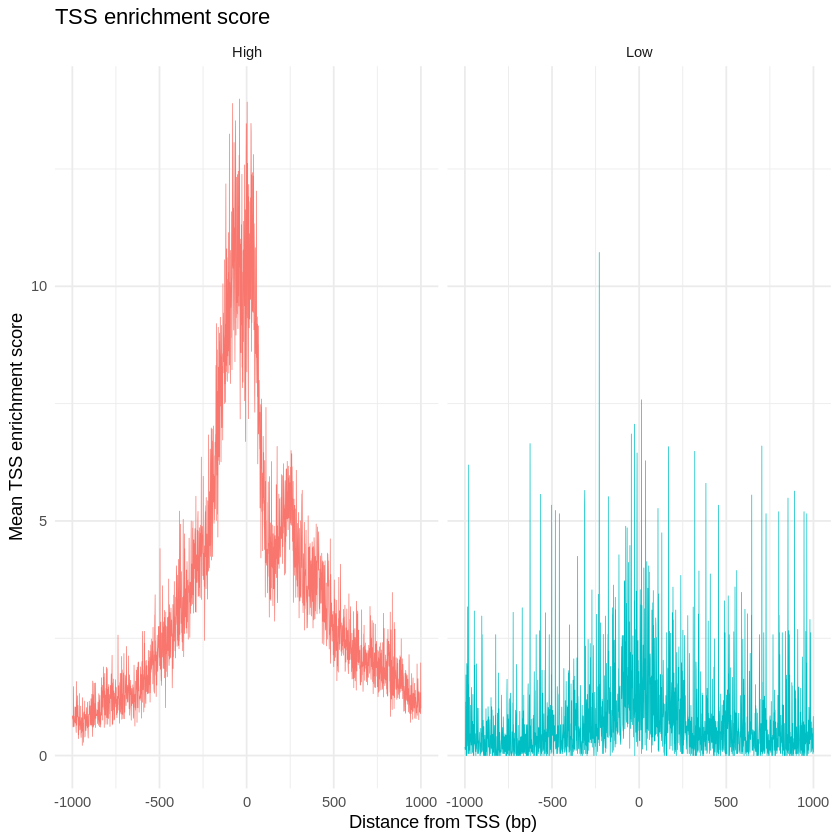

In [15]:
LT$high.tss <- ifelse(LT$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(LT, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

In [16]:
LT <- subset(LT, 
             subset = peak_region_fragments > 1000 & 
             peak_region_fragments < 20000 & 
             pct_reads_in_peaks > 30 & 
             blacklist_ratio < 0.02 & 
             nucleosome_signal < 4 & 
             TSS.enrichment > 2)
LT

An object of class Seurat 
364214 features across 648 samples within 2 assays 
Active assay: peaks (182107 features, 0 variable features)
 1 other assay present: RNA

In [17]:
# save the IDs of the high quality cells

filtered <- rownames(LT@meta.data)

write.csv(filtered,'./write/scATAC_LT_filtered_cells.csv')

In [18]:
LT <- RunTFIDF(LT)
LT <- FindTopFeatures(LT, min.cutoff = 'q15')

LT <- RunSVD(
  object = LT,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi',
  fastpath=FALSE,
  verbose=TRUE
)

Performing TF-IDF normalization
Running SVD
Scaling cell embeddings


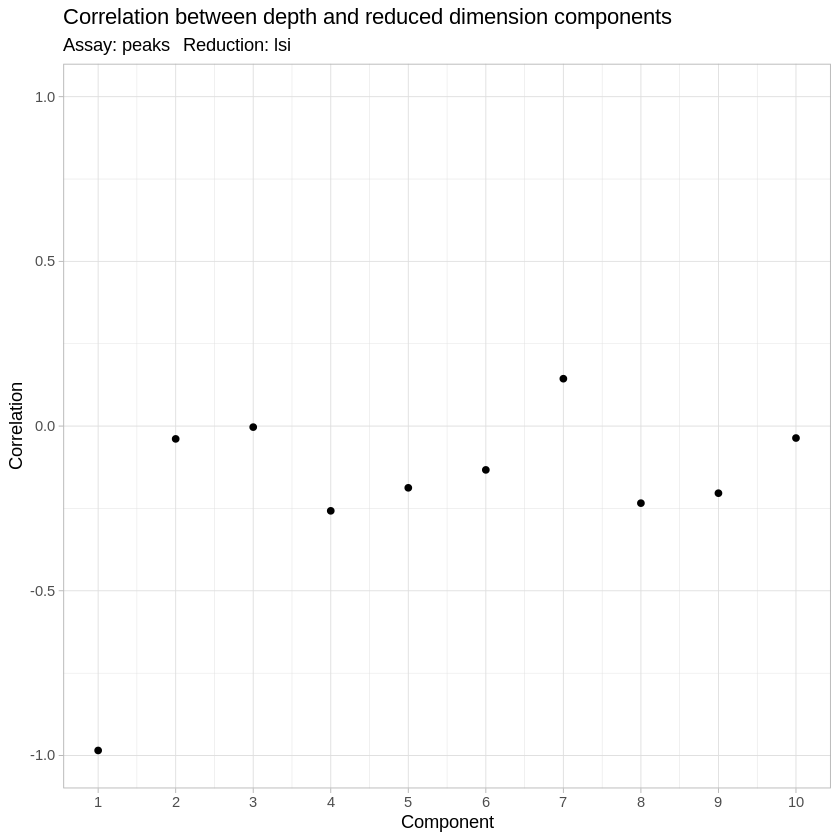

In [19]:
DepthCor(LT)

In [20]:
LT <- RunUMAP(object = LT, reduction = 'lsi', dims = 2:30)
LT <- FindNeighbors(object = LT, reduction = 'lsi', dims = 2:30, k.param = 20)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"15:37:03 UMAP embedding parameters a = 0.9922 b = 1.112
15:37:03 Read 648 rows and found 29 numeric columns
15:37:03 Using Annoy for neighbor search, n_neighbors = 30
15:37:03 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
15:37:03 Writing NN index file to temp file /tmp/RtmpAm5uQK/file20839ba6fc4
15:37:03 Searching Annoy index using 1 thread, search_k = 3000
15:37:03 Annoy recall = 100%
15:37:04 Commencing smooth kNN distance calibration using 1 thread
15:37:06 Initializing from normalized Laplacian + noise
15:37:06 Commencing optimization 

Warning message:
"The following arguments are not used: k.param"Warning message:
"The following arguments are not used: k.param"

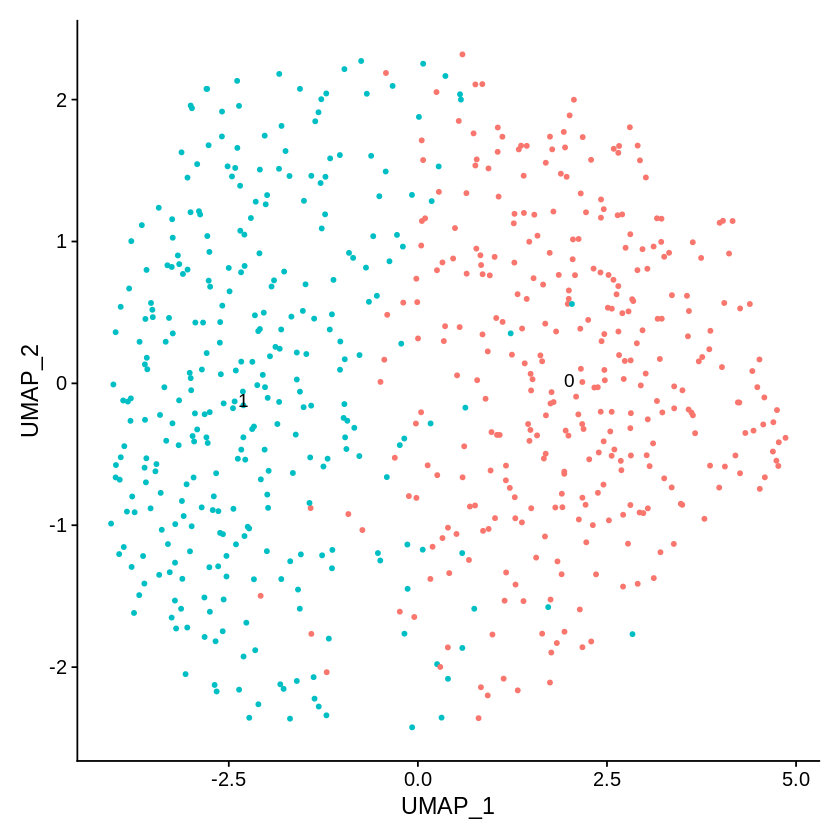

In [21]:
LT <- FindClusters(object = LT, verbose = FALSE, resolution = 0.5, k.param = 20, algorithm = 2)
DimPlot(object = LT, label = TRUE) + NoLegend()

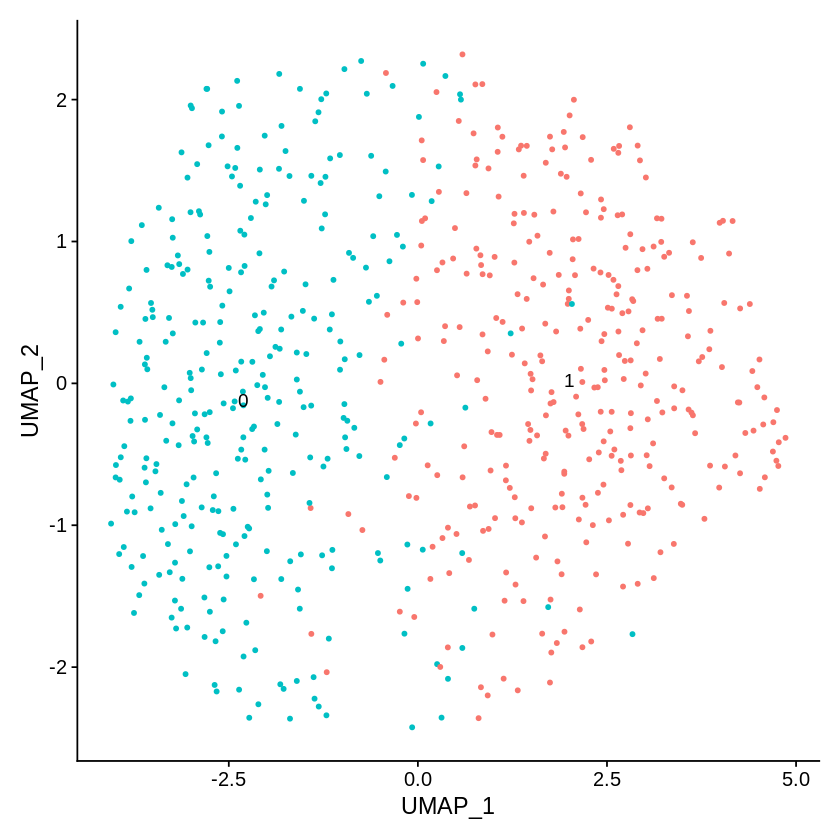

In [24]:
new.cluster.ids <- c("1", "0")
names(new.cluster.ids) <- levels(LT)
LT <- RenameIdents(LT, new.cluster.ids)
DimPlot(object = LT, label = TRUE) + NoLegend()

In [25]:
# add information about male cells as metainfomation

counts_df <- GetAssayData(object = LT, slot = "counts")
male_counts <- colSums(counts_df[181990:182107,])
LT$male <- male_counts
LT$male_binary <- LT$male
LT$male_binary[LT$male_binary > 0] <- 1

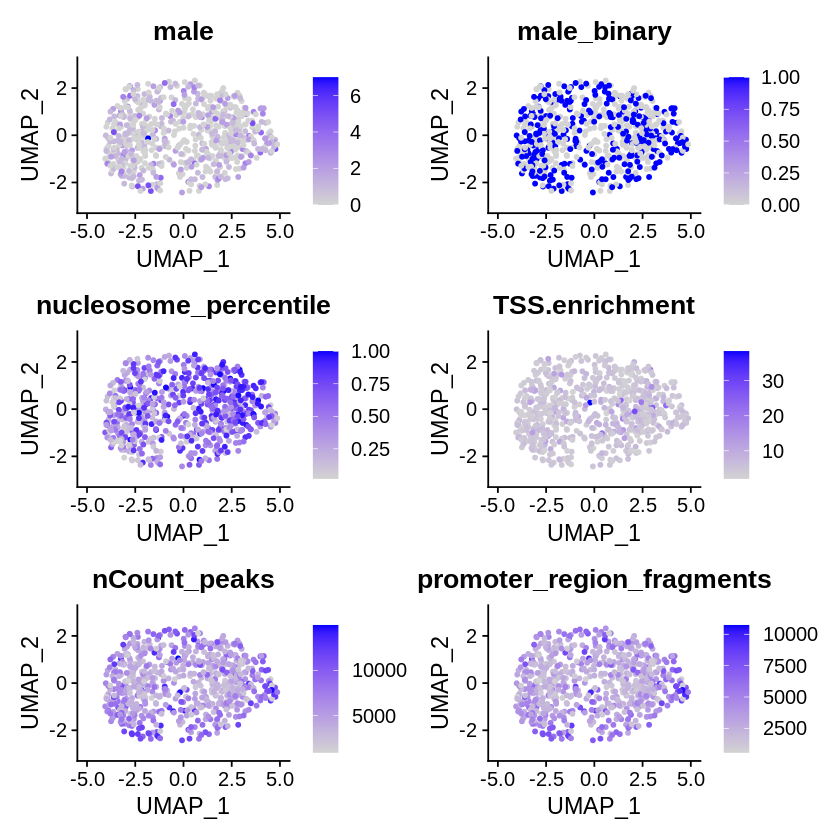

In [26]:
# plot some general stats about cells

FeaturePlot(LT, features = c("male", 
                               "male_binary", 
                               "nucleosome_percentile", 
                               'TSS.enrichment', 
                               'nCount_peaks',
                               'promoter_region_fragments'
                               ), ncol = 2)

### code if ever want to extract promotor regions only - for future use

library(biomaRt)
#library(regioneR)
library(EnsDb.Mmusculus.v79)

mart <- useDataset("mmusculus_gene_ensembl", useMart("ensembl"))
att <- listAttributes(mart)

transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "ensembl_gene_id","gene_biotype", "ensembl_transcript_id"),
      filters ="biotype",
      values  =c("protein_coding"),
      mart    =mart)

#Build a GRanges with regioneR's toGRanges function
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")

#get the flanking regions from the start of the transcripts and from the end
flanking <- c(flank(transcripts.gr, 1000, start = TRUE),
              flank(transcripts.gr, 1000, start = FALSE))

#Change the chromosomes names from Ensembl (1,2,3...) to UCSC (chr1, chr2, ch3...) so they match the chromosome names in the BSgenome
seqlevelsStyle(flanking) <- "UCSC"


#And get the sequences
seqs <- getSeq(EnsDb.Mmusculus.v79, flanking)

In [27]:
#extract gene coordinates from Ensembl, and ensure name formatting is consistent with  Seurat object 
gene.coords <- genes(EnsDb.Mmusculus.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

# build a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(LT),
  chunk = 10
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- make.unique(gene.key[rownames(gene.activities)])
gene.activities <- gene.activities[rownames(gene.activities)!="",]

#Add the gene activity matrix to the Seurat object as a new assay, and normalize it
LT[['RNA']] <- CreateAssayObject(counts = gene.activities)
LT <- NormalizeData(
  object = LT,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(LT$nCount_RNA)
)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 3 out-of-bound ranges located on sequences
  JH584293.1, JH584295.1, and JH584296.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."Extracting reads overlapping genomic regions
Constructing matrix


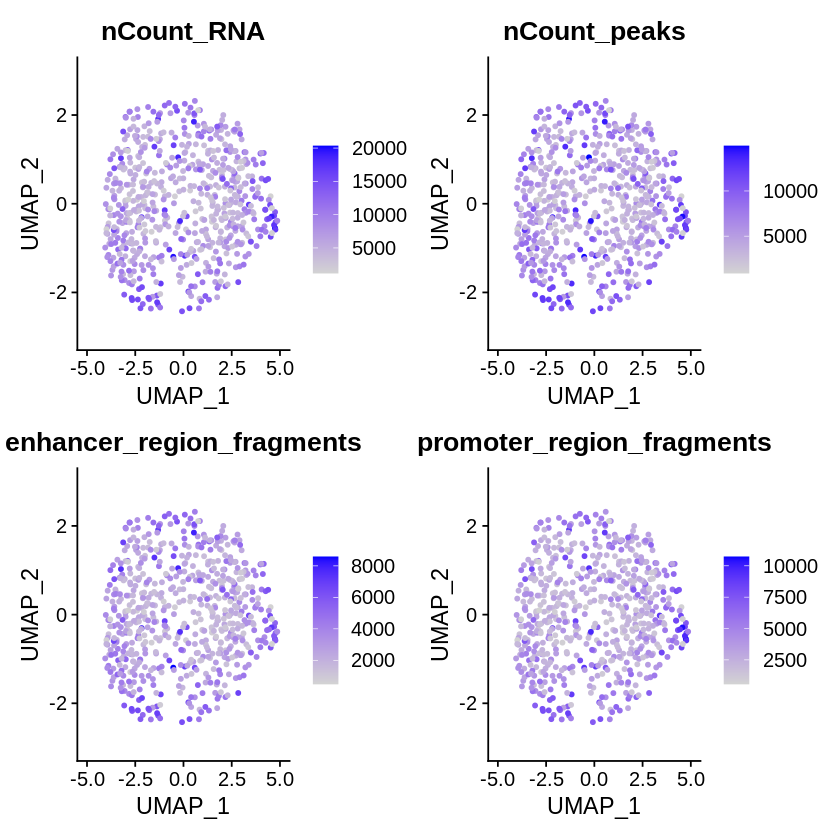

In [28]:
FeaturePlot(LT, features = c("nCount_RNA", 
                               "nCount_peaks",
                             'enhancer_region_fragments',
                             'promoter_region_fragments'
                             
                               ), ncol = 2)

In [29]:
DefaultAssay(LT) <- 'RNA'

# finds out the differences between both groups
LT.markers <- FindAllMarkers(LT, only.pos = TRUE, min.pct = 0.05, logfc.threshold = 0.2)

Calculating cluster 1
Calculating cluster 0


In [30]:
head(LT.markers)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Jun,2.069139e-08,0.2929917,0.741,0.646,0.0004241735,1,Jun
Klf6,3.452679e-08,0.2680566,0.687,0.554,0.0007077992,1,Klf6
Fosb,7.955631e-08,0.3153108,0.578,0.434,0.0016309044,1,Fosb
Nfe2l3,2.736550e-07,0.2519772,0.346,0.184,0.0056099274,1,Nfe2l3
Egr1,2.875828e-07,0.2723506,0.648,0.544,0.0058954478,1,Egr1
Polg2,5.213470e-07,0.2746964,0.548,0.405,0.0106876137,1,Polg2


In [31]:
LT.markers %>% filter(p_val_adj < 0.05)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Jun,2.069139e-08,0.2929917,0.741,0.646,4.241735e-04,1,Jun
Klf6,3.452679e-08,0.2680566,0.687,0.554,7.077992e-04,1,Klf6
Fosb,7.955631e-08,0.3153108,0.578,0.434,1.630904e-03,1,Fosb
Nfe2l3,2.736550e-07,0.2519772,0.346,0.184,5.609927e-03,1,Nfe2l3
Egr1,2.875828e-07,0.2723506,0.648,0.544,5.895448e-03,1,Egr1
Polg2,5.213470e-07,0.2746964,0.548,0.405,1.068761e-02,1,Polg2
Ddx5,1.737583e-06,0.2641549,0.530,0.399,3.562044e-02,1,Ddx5
Abi3,3.018305e-11,0.3088843,0.706,0.485,6.187524e-07,0,Abi3
Ctif,1.645943e-09,0.2596000,0.927,0.822,3.374183e-05,0,Ctif


In [32]:
#write markers to file
write.csv(LT.markers %>% filter(p_val_adj < 0.05),'./write/HSC_markers_genes_macs2.csv')

In [33]:
print('LT.markers - cluster 0')
print((LT.markers) %>% filter(cluster == 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('LT.markers - cluster 1')
print((LT.markers) %>% filter(cluster == 1) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

[1] "LT.markers - cluster 0"
   n
1 13
[1] "LT.markers - cluster 1"
  n
1 7


ABI3 expression is frequently lost or reduced in
invasive cancer. Ectopic expression of ABI3 inhibits metastasis
and cell migration
Latini, F. R. et al. ABI3 ectopic expression reduces in vitro and in vivo cell
growth properties while inducing senescence. BMC Cancer 11, 11 (2011).

Ctif - translation initiation factor
formin-like 3 (FMNL3) - promotes proliferation

Smad7 promotes HSC self-renewal in vivo (but is inhibitory, inhibitory smad) 
https://ashpublications.org/blood/article/108/13/4246/6605/Smad7-promotes-self-renewal-of-hematopoietic-stem

RARA (Retinoic Acid Receptor Alpha) 

Polg2 Mitochondrial polymerase processivity subunit

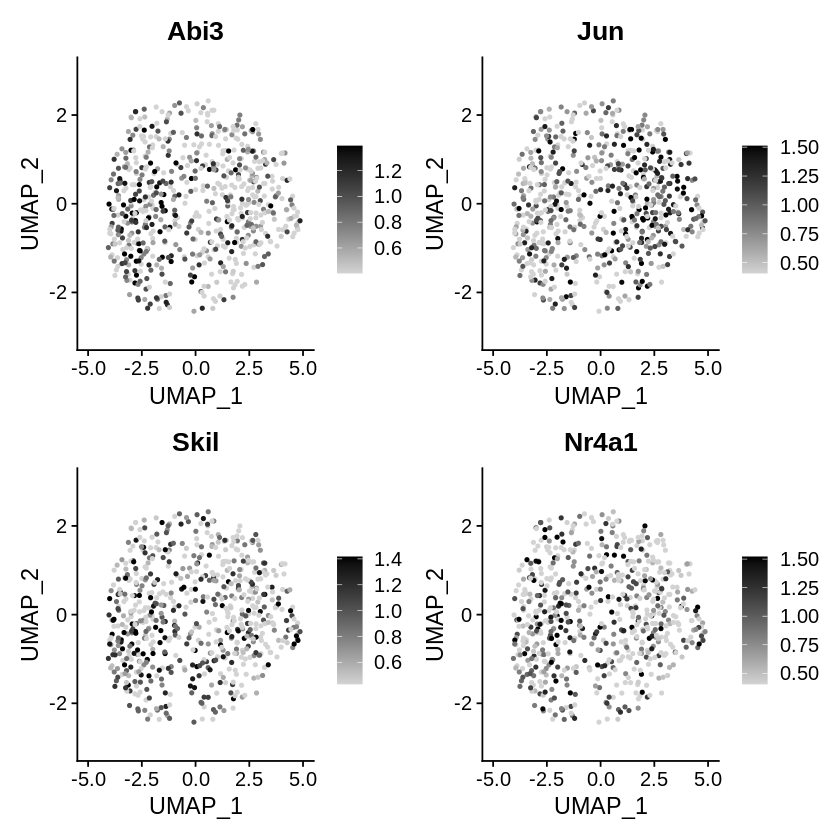

In [34]:
DefaultAssay(LT) <- 'RNA'

baseplot2 = FeaturePlot(LT, features = c('Abi3', 'Jun', 'Skil', 'Nr4a1'
                               ), 
                              cols = c('lightgrey', 'black'),
                              pt.size = 0.8,
                              ncol = 2,
                              min.cutoff = 'q5',
                              max.cutoff = 'q90'
                       )

#baseplot2 + coord_fixed(ratio = 0.75) 
baseplot2

### look at differentially accessible peaks

In [35]:
DefaultAssay(LT) <- 'peaks'

da_peaks_0vs1 <- FindMarkers(
  object = LT,
  ident.1 = '0', 
  ident.2 = '1',
  logfc.threshold = 0.2,
  min.pct = 0.05,
  only.pos = FALSE,
  test.use = 'LR',
  latent.vars = 'nCount_peaks'
)

print('0vs1_up_1')
print((da_peaks_0vs1) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('0vs1_up_0')
print((da_peaks_0vs1) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

[1] "0vs1_up_1"
  n
1 1
[1] "0vs1_up_0"
   n
1 14


In [36]:
#10 regions that are specifically enriched
(da_peaks_0vs1)[1:10,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr18:75387430-75387731,1.713254e-10,0.7635979,0.266,0.075,3.119955e-05
chr3:8766635-8766936,3.432517e-10,0.6892210,0.335,0.127,6.250854e-05
chr7:13302804-13303105,5.855407e-10,0.8906640,0.234,0.060,1.066311e-04
chr18:35865418-35865719,3.510479e-09,1.4184605,0.082,0.000,6.392828e-04
chr15:74988603-74988904,6.922865e-09,0.6797298,0.307,0.117,1.260702e-03
chr16:37788449-37788750,1.349743e-08,0.6250412,0.269,0.084,2.457976e-03
chr4:32279821-32280122,1.579860e-08,1.3003022,0.114,0.012,2.877036e-03
chr11:103685220-103685521,2.701593e-08,0.8671336,0.177,0.039,4.919791e-03
chr2:38536513-38536814,3.087443e-08,0.6475098,0.288,0.111,5.622450e-03


In [37]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
seqlevelsStyle(gene.ranges) <- 'UCSC'
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]
gene.ranges <- keepStandardChromosomes(gene.ranges, pruning.mode = 'coarse')

In [38]:
open_0 <- rownames(da_peaks_0vs1[da_peaks_0vs1$avg_logFC < -0.20, ])
open_1 <- rownames(da_peaks_0vs1[da_peaks_0vs1$avg_logFC > 0.20, ])
closest_0 <- ClosestFeature(regions = open_0, annotation = gene.ranges, sep = c(':', '-'))
closest_1 <- ClosestFeature(regions = open_1, annotation = gene.ranges, sep = c(':', '-'))
head(closest_1)

,gene_id,gene_name,gene_biotype,seq_coord_system,symbol,entrezid,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<chr>,<I<named list>>,<chr>,<chr>,<int>
ENSMUSG00000025880,ENSMUSG00000025880,Smad7,protein_coding,chromosome,Smad7,17131,chr18:75367529-75395935,chr18:75387430-75387731,0
ENSMUSG00000040269,ENSMUSG00000040269,Mrps28,protein_coding,chromosome,Mrps28,66230,chr3:8802146-8923918,chr3:8766635-8766936,35209
ENSMUSG00000056394,ENSMUSG00000056394,Lig1,protein_coding,chromosome,Lig1,NA,chr7:13277283-13311433,chr7:13302804-13303105,0
ENSMUSG00000046668,ENSMUSG00000046668,Cxxc5,protein_coding,chromosome,Cxxc5,67393,chr18:35829818-35861687,chr18:35865418-35865719,3730
ENSMUSG00000022586,ENSMUSG00000022586,Ly6i,protein_coding,chromosome,Ly6i,57248,chr15:74979534-74983430,chr15:74988603-74988904,5172
ENSMUSG00000022816,ENSMUSG00000022816,Fstl1,protein_coding,chromosome,Fstl1,14314,chr16:37776873-37836514,chr16:37788449-37788750,0


In [39]:
head(closest_0)

,gene_id,gene_name,gene_biotype,seq_coord_system,symbol,entrezid,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<chr>,<I<named list>>,<chr>,<chr>,<int>
ENSMUSG00000038943,ENSMUSG00000038943,Prc1,protein_coding,chromosome,Prc1,233406,chr7:80294450-80316259,chr7:80294148-80294449,0
ENSMUSG00000024941,ENSMUSG00000024941,Scyl1,protein_coding,chromosome,Scyl1,78891,chr19:5758427-5771401,chr19:5795060-5795361,23658
ENSMUSG00000052684,ENSMUSG00000052684,Jun,protein_coding,chromosome,Jun,16476,chr4:95049034-95052222,chr4:95049177-95049478,0
ENSMUSG00000024941.1,ENSMUSG00000024941,Scyl1,protein_coding,chromosome,Scyl1,78891,chr19:5758427-5771401,chr19:5795633-5795934,24231
ENSMUSG00000055148,ENSMUSG00000055148,Klf2,protein_coding,chromosome,Klf2,16598,chr8:72319033-72321656,chr8:72324499-72324800,2842
ENSMUSG00000049775,ENSMUSG00000049775,Tmsb4x,protein_coding,chromosome,Tmsb4x,19241,chrX:167207093-167209315,chrX:167209038-167209339,0


In [40]:
# overlap the peaks and the mapping to genes file to save later

peaks_all_df <- (da_peaks_0vs1[da_peaks_0vs1$p_val_adj < 0.05, ])
peaks_all <- rownames(peaks_all_df)
closest_all <- ClosestFeature(regions = peaks_all, annotation = gene.ranges, sep = c(':', '-'))
peaks_all_df$query_region <- rownames(peaks_all_df) # makes index to column
peaks_all_df <- merge(peaks_all_df, closest_all, by = 'query_region')

#peaks and genes file
write.csv(peaks_all_df,'./write/HSC_peaks_genes_macs2.csv')

#### played around with the options for a bit - wasn't that clear to figure out - decided to manipulated in illustrtor

FontSize(x.title = 20, y.title = 20) + coord_fixed(ratio = 1) +
theme(axis.text.x = element_text(size=18), axis.text.y = element_text(size=18)) +
NoLegend()

Warning message:
"Removed 3 rows containing missing values (position_stack)."Warning message:
"Removed 46 rows containing missing values (position_stack)."

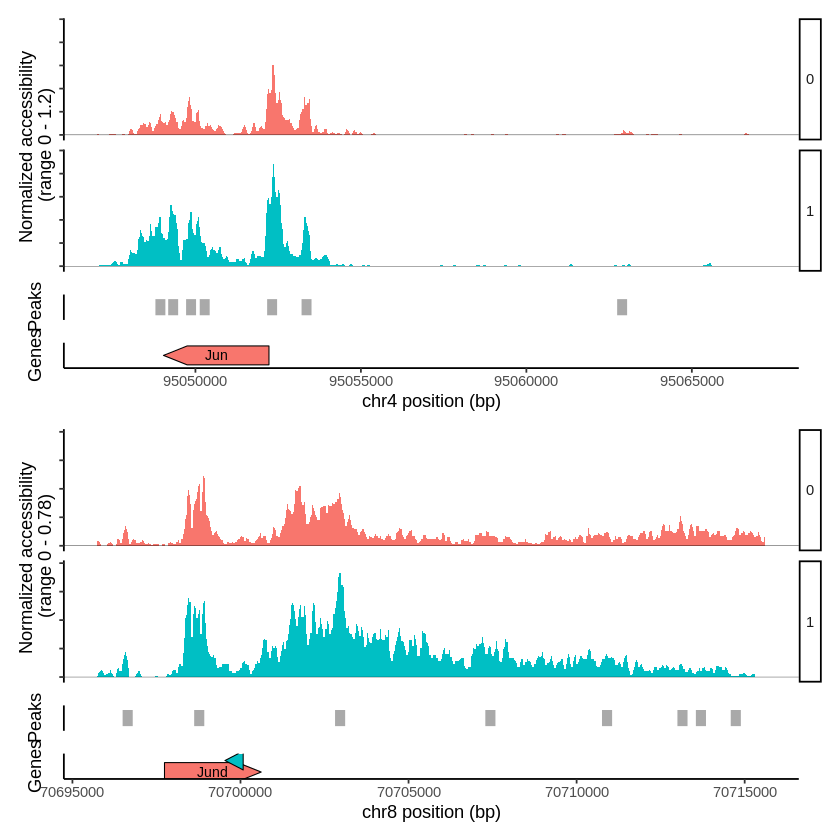

In [41]:
# set plotting order
levels(LT) <- c('0','1')

region1 <- GRangesToString(subset(gene.coords, symbol=="Jun"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Jund"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = gene.ranges,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  #peaks = NULL,
  extend.upstream = 2000,
  extend.downstream = 15000,
  ncol = 1
)

Warning message:
"Removed 194 rows containing missing values (position_stack)."Warning message:
"Removed 649 rows containing missing values (position_stack)."Warning message:
"Removed 1 rows containing missing values (geom_segment)."

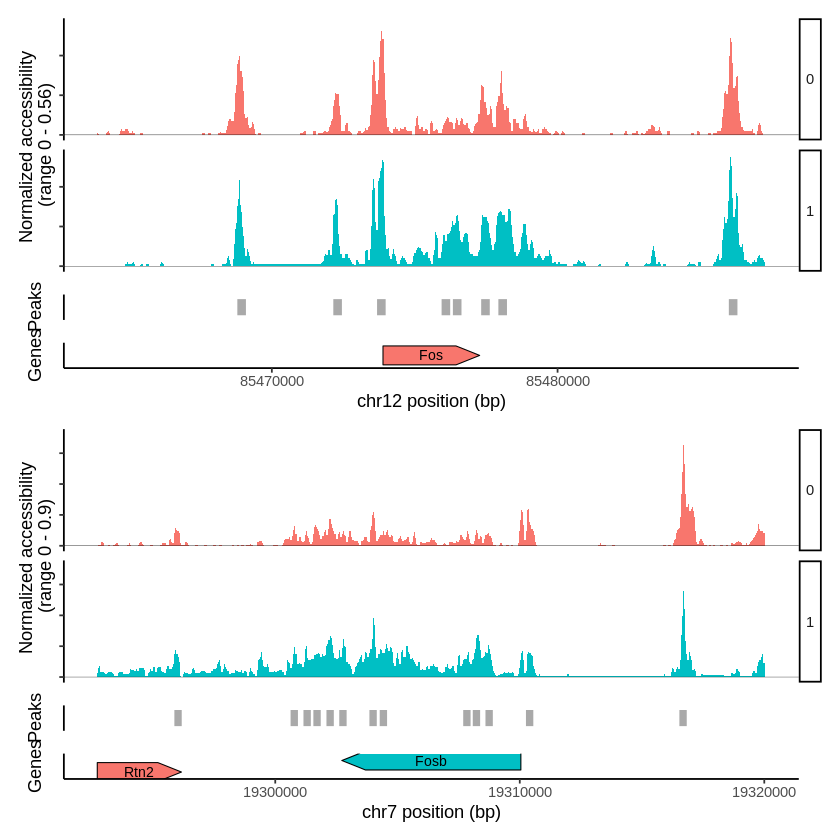

In [42]:
# set plotting order
levels(LT) <- c('0','1')

region1 <- GRangesToString(subset(gene.coords, symbol=="Fos"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Fosb"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = gene.ranges,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  #peaks = NULL,
  extend.upstream = 10000,
  extend.downstream = 10000,
  ncol = 1
)

Warning message:
"Removed 1 rows containing missing values (geom_segment)."Warning message:
"Removed 2295 rows containing missing values (position_stack)."

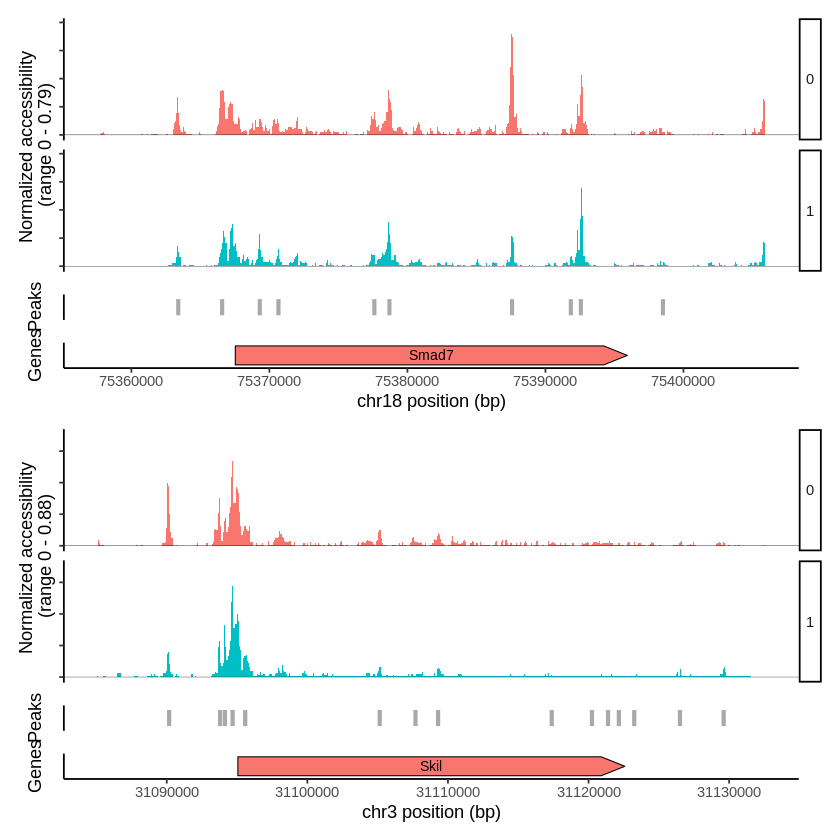

In [43]:
# set plotting order
levels(LT) <- c('0','1')

region1 <- GRangesToString(subset(gene.coords, symbol=="Smad7"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Skil"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = gene.ranges,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  #peaks = NULL,
  extend.upstream = 10000,
  extend.downstream = 10000,
  ncol = 1
)

Warning message:
"Removed 426 rows containing missing values (position_stack)."

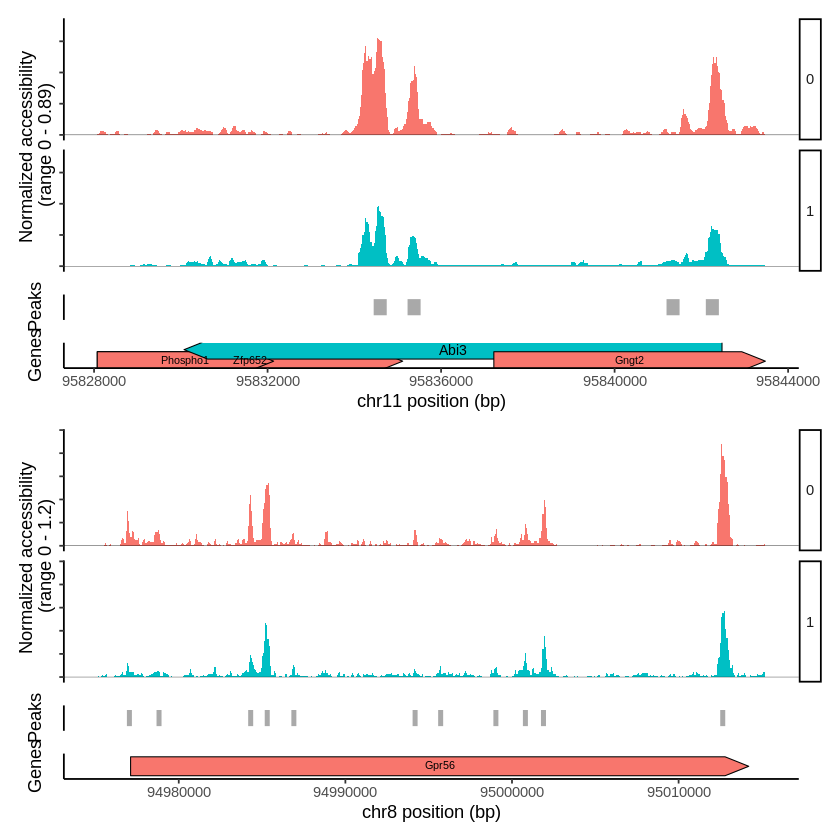

In [44]:
# set plotting order
levels(LT) <- c('0','1')

region1 <- GRangesToString(subset(gene.coords, symbol=="Abi3"))
region2 <- GRangesToString(subset(gene.coords, symbol=="Gpr56"))

CoveragePlot(
  object = LT,
  region = c(region1, region2),
  sep = c(":", "-"),
  annotation = gene.ranges,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  #peaks = NULL,
  extend.upstream = 2000,
  extend.downstream = 1000,
  ncol = 1
)

#Gpr56

Warning message:
"Removed 4 rows containing missing values (position_stack)."

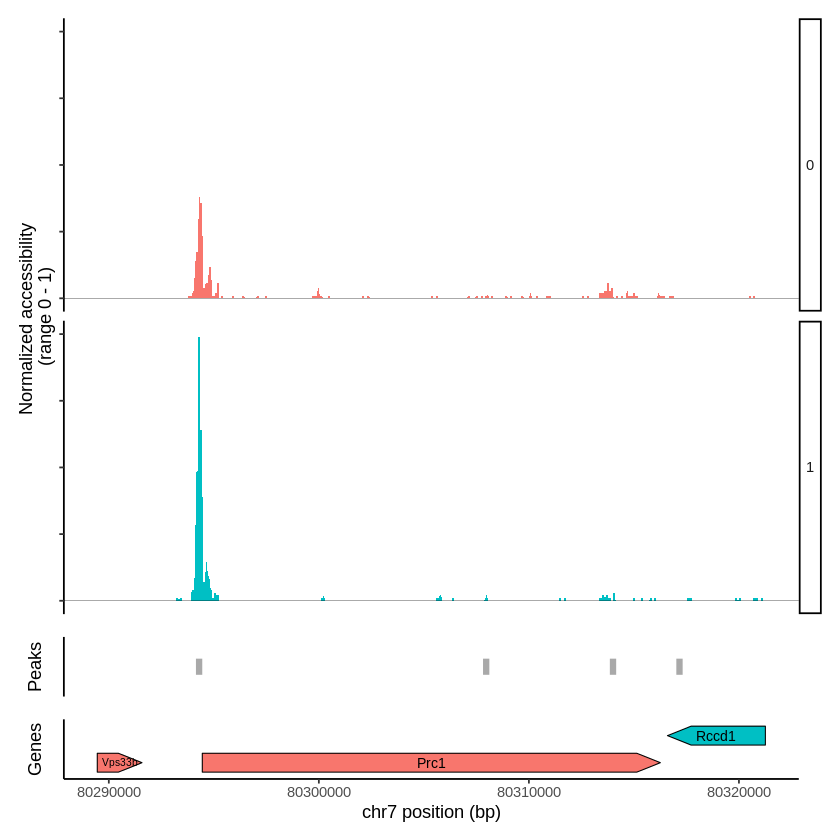

In [45]:
region1 <- GRangesToString(subset(gene.coords, symbol=="Prc1"))

plot = CoveragePlot(
  object = LT,
  region = region1,
  sep = c(":", "-"),
  annotation = gene.ranges,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  extend.upstream = 5000,
  extend.downstream = 5000
) 
plot

Warning message:
"Removed 1074 rows containing missing values (position_stack)."

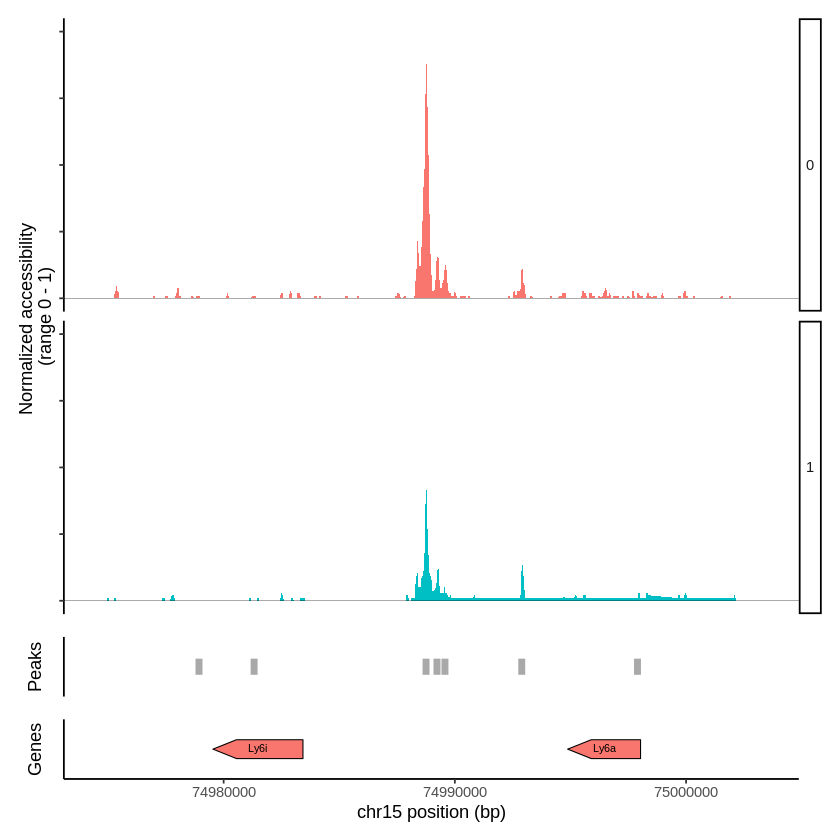

In [46]:
region1 <- GRangesToString(subset(gene.coords, symbol=="Ly6i"))

plot = CoveragePlot(
  object = LT,
  region = region1,
  sep = c(":", "-"),
  annotation = gene.ranges,
  peaks = StringToGRanges(regions = rownames(LT), sep = c(":", "-")),
  extend.upstream = 5000,
  extend.downstream = 20000
) 
plot

## chromVar

#### defined list

that's how to get out only specific transcription factors

`# define list of motifs I want to retrieve
opts <- list()
opts[["species"]] <- 9606
opts[["name"]] <- c("FOS", "CREB1", "STAT3", 'IRF9', "NFKB1")
opts[["all_versions"]] <- TRUE`



In [47]:
# Get a list of motif position frequency matrices from the JASPAR database
DefaultAssay(LT) <- 'peaks'
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

# Scan the DNA sequence of each peak for the presence of each motif
motif.matrix <- CreateMotifMatrix(
  features = StringToGRanges(rownames(LT), sep = c(":", "-")),
  pwm = pfm,
  genome = 'mm10',
  sep = c(":", "-"),
  use.counts = FALSE
)

# Create a new Mofif object to store the results
motif <- CreateMotifObject(
  data = motif.matrix,
  pwm = pfm
)

# Add the Motif object to the assay
LT[['peaks']] <- AddMotifObject(
  object = LT[['peaks']],
  motif.object = motif
)

# calculates sequence statistics for motif enrichment

LT <- RegionStats(
  object = LT,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  sep = c(":", "-")
)


Attaching package: 'XVector'

The following object is masked from 'package:purrr':

    compact


Attaching package: 'Biostrings'

The following object is masked from 'package:base':

    strsplit



In [48]:
# run ChromVAR
LT <- RunChromVAR(
  object = LT,
  genome = BSgenome.Mmusculus.UCSC.mm10
)
DefaultAssay(LT) <- 'chromvar'

Computing GC bias per region
Selecting background regions
Computing motif deviations from background
Constructing chromVAR assay


In [49]:
#pairwise comparisons between clusters

differential.activity <- FindMarkers(
  object = LT,
  ident.1 = '0',
  ident.2 = '1',
  only.pos = FALSE,
  test.use = 'LR',
  min.pct = 0,
  logfc.threshold = 0,
  latent.vars = 'nCount_peaks'
)

#some meangering to get the motifnames displayed in the tables
motifnames <- GetMotifData(object = LT, assay = 'peaks', slot = 'motif.names')
motifnames <- t(as.data.frame((motifnames)))
differential.activity_0vs1 <- merge(motifnames, differential.activity, by=0, all=FALSE)

In [50]:
print('0vs1_up_1')
print((differential.activity_0vs1) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))
print('0vs1_up_0')
print((differential.activity_0vs1) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

[1] "0vs1_up_1"
   n
1 50
[1] "0vs1_up_0"
   n
1 62


In [51]:
# up in cluster 1 (compared to 0)
((differential.activity_0vs1) %>% filter(avg_logFC < 0) %>% filter(p_val_adj < 0.01) %>% arrange(by_group = avg_logFC))[1:50,]

,Row.names,V1,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<I<chr>>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MA1102.1,CTCFL,7.927300e-55,-2.15422394,0.225,0.750,3.583139e-52
2,MA0506.1,NRF1,6.264972e-33,-1.42626055,0.269,0.605,2.831767e-30
3,MA0740.1,KLF14,2.732835e-35,-1.19522862,0.269,0.542,1.235242e-32
4,MA0139.1,CTCF,2.288320e-69,-1.19130530,0.190,0.798,1.034320e-66
5,MA0685.1,SP4,4.248148e-33,-1.14849845,0.272,0.545,1.920163e-30
6,MA1125.1,ZNF384,2.170439e-10,-0.99310237,0.358,0.515,9.810385e-08
7,MA0657.1,KLF13,2.469494e-14,-0.96242834,0.332,0.521,1.116211e-11
8,MA0747.1,SP8,5.181906e-16,-0.88201626,0.342,0.476,2.342222e-13
9,MA0095.2,YY1,1.106697e-18,-0.88093170,0.323,0.602,5.002270e-16


In [52]:
# up in cluster 0 (compared to 1)
((differential.activity_0vs1) %>% filter(avg_logFC > 0) %>% filter(p_val_adj < 0.01) %>% arrange(by_group = p_val_adj))[1:30,]

Row.names,V1,p_val,avg_logFC,pct.1,pct.2,p_val_adj
<I<chr>>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0477.1,FOSL1,8.250040e-74,8.0039860,0.715,0.102,3.729018e-71
MA0490.1,JUNB,5.449612e-72,8.2817046,0.706,0.093,2.463225e-69
MA1141.1,FOS::JUND,7.793468e-71,7.7154688,0.703,0.105,3.522648e-68
MA0491.1,JUND,1.701022e-70,7.7972978,0.699,0.108,7.688618e-68
MA0478.1,FOSL2,3.450343e-70,8.6794369,0.706,0.108,1.559555e-67
MA1130.1,FOSL2::JUN,4.349951e-70,8.3555243,0.709,0.108,1.966178e-67
MA1137.1,FOSL1::JUNB,6.467192e-70,7.8691009,0.699,0.096,2.923171e-67
MA0476.1,FOS,1.513846e-69,7.9674052,0.703,0.099,6.842585e-67
MA1134.1,FOS::JUNB,2.185735e-69,7.5171647,0.696,0.108,9.879522e-67


**up in 1**


MA0841.1	NFE2 # up in megakaryocyte production - same motif as AP-1

MA0099.3	FOS::JUN   
MA0036.3	GATA2
MA0795.1	SMAD3
MA0684.1	RUNX3
MA0080.4	SPI1



MA0511.2	RUNX2

**up in 0**


MA0741.1	KLF16 # erythroid commitment  
MA0060.3	NFYA commitment + self renewal https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3286206/  
MA0506.1	NRF1 # metabolic gene   
MA0139.1	CTCF  
MA0095.2	YY1  
MA0079.3	SP1  

MA0685.1	SP4


MA0599.1	KLF5	homing of HSCs https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3627399/
MA0506.1	NRF1 # metabolic gene  
MA0060.3	NFYA commitment + self renewal https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3286206/
MA0502.1	NFYB
MA0095.2	YY1



MA0139.1	CTCF  
MA1122.1	TFDP1 # e2f cell cycle  
MA0470.1	E2F4  
MA0131.2	HINFP HINFP activates H4 gene expression  

MA0162.3	EGR1  

MA0772.1	IRF7  



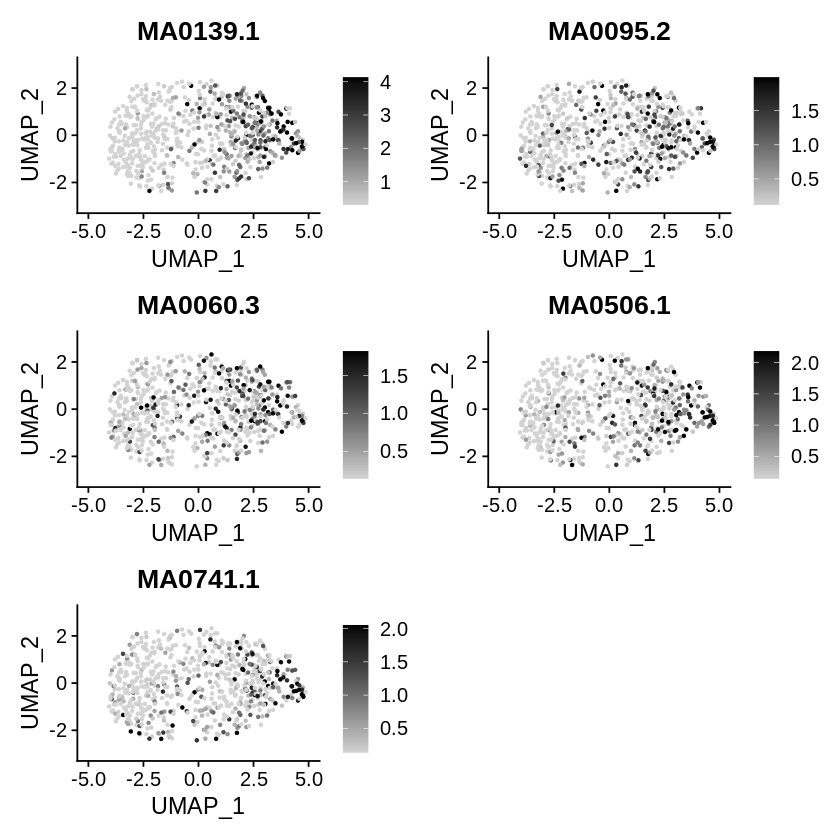

In [53]:
DefaultAssay(LT) <- 'chromvar'

baseplot = FeaturePlot(object = LT,
                          features = c(
                                       'MA0139.1',
                                       'MA0095.2', 
                                       'MA0060.3',
                                        "MA0506.1",
                                        'MA0741.1'
                                        ),
                          min.cutoff = 'q10',
                          max.cutoff = 'q90',
                          cols = c('lightgrey', 'black'),
                          pt.size = 0.6,
                          ncol = 2,
                        )
 
baseplot

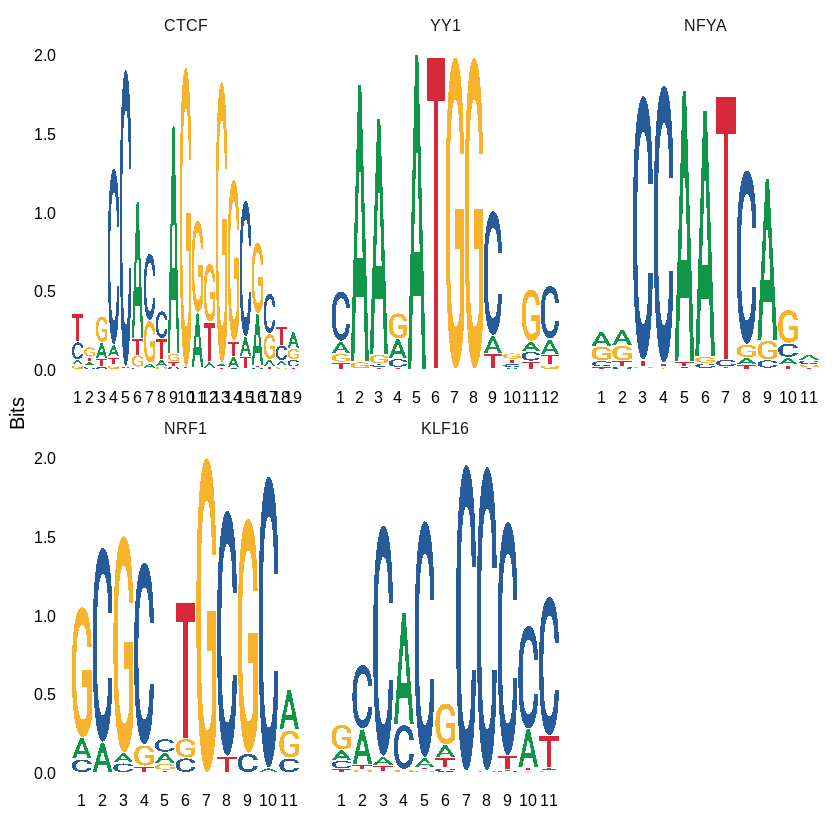

In [54]:
MotifPlot(
  object = LT,
  motifs = c('MA0139.1',
            'MA0095.2',
            'MA0060.3',
            "MA0506.1",
            'MA0741.1'
            ),
  assay = 'peaks'
)

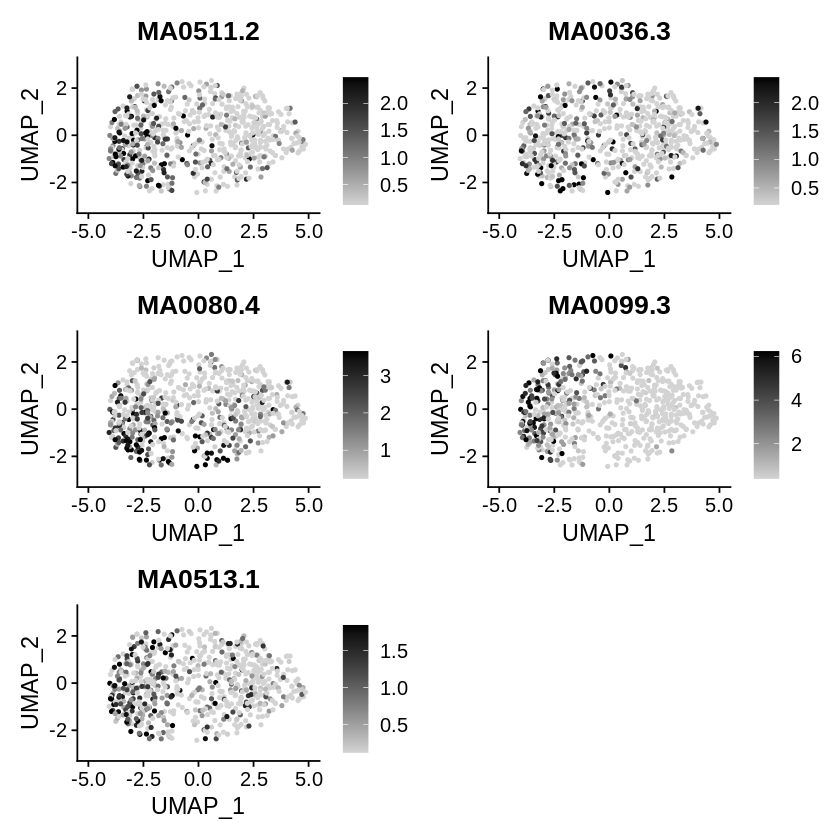

In [55]:
baseplot = FeaturePlot(
  object = LT,
  features = c('MA0511.2',
               'MA0036.3',
               "MA0080.4",         
               'MA0099.3',
               "MA0513.1"
                ),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  cols = c('lightgrey', 'black'),
  pt.size = 0.8,
  ncol = 2,
)

baseplot

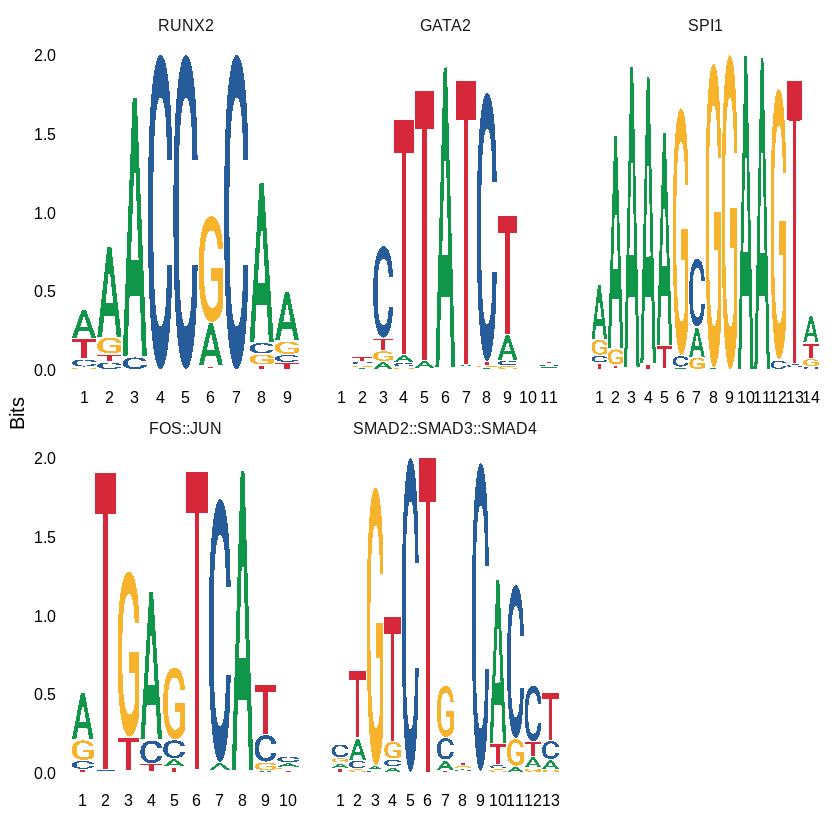

In [56]:
MotifPlot(
  object = LT,
  motifs = c(
      'MA0511.2',
      'MA0036.3',
      "MA0080.4",         
      'MA0099.3',
      "MA0513.1"
                ),
  assay = 'peaks'
)

In [57]:
# enriched Motifs in clusters

write.csv(differential.activity_0vs1,'./write/HSC_chromVAR_macs2.csv')

#write.csv(differential.activity_0vs1 %>% filter(p_val_adj < 0.05),'./write/HSC_chromVAR_macs2.csv')

In [58]:
# with chromvar

### save HSC object

saveRDS(LT, file = "./sc_objects/scATAC_HSC_processed_chromvar_macs2.rds")

In [59]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Mmusculus.UCSC.mm10_1.4.0 BSgenome_1.54.0                   
 [3] rtracklayer_1.46.0                 Biostrings_2.54.0                 
 [5] XVector_0.26.0                     SingleCellExperiment_1.8.0        
 [7] diffloop_1.14.0                    SummarizedExperiment_1.16.0       
 